In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
#If you haven't install iisignature,use the code:   pip install iisignature


 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [14]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [15]:
#Calculating daily returns
stock_data['Return'] = stock_data.groupby('Company')['Close'].pct_change()
stock_data['OReturn'] = stock_data.groupby('Company')['Open'].pct_change()
stock_data.dropna(subset=['Return'], inplace=True)
stock_data.dropna(subset=['OReturn'], inplace=True)








In [16]:
#Delete useless company
target_date = pd.Timestamp('2022-02-01')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [17]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [24]:
#Data for simulate
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2022-06-16')

#Get data for a specific time period
simulate_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]








In [23]:
unique_dates_count = simulate_stock_data['Date'].nunique()
print(unique_dates_count)

unique_companys_count = simulate_stock_data['Company'].nunique()
print(unique_companys_count)


95
486


In [25]:
#Calculate mean &std of data
company_stats_C = simulate_stock_data.groupby('Company')['Return'].agg(['mean', 'std']).rename(columns={'mean': 'cmiu', 'std': 'csigma'})
company_stats_O = simulate_stock_data.groupby('Company')['OReturn'].agg(['mean', 'std']).rename(columns={'mean': 'omiu', 'std': 'osigma'})


#Simulate the return and open return
np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_C, on='Company')
simulate_stock_data['sim_creturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['cmiu'], row['csigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['cmiu', 'csigma'])


np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_O, on='Company')
simulate_stock_data['sim_oreturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['omiu'], row['osigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['omiu', 'osigma'])

simulate_stock_data['sim_Close'] = np.nan
simulate_stock_data['sim_Open'] = np.nan


# Sort the data by Company and Date
simulate_stock_data = simulate_stock_data.sort_values(by=['Company', 'Date'])

# Function to calculate simulated close and open prices
def calculate_sim(group):
    group = group.sort_values(by='Date').reset_index(drop=True)
    for i in range(len(group)):
        if i == 0:
            group.at[i, 'sim_Close'] = group.at[i, 'Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i, 'Open'] * (1 + group.at[i, 'sim_oreturn'])
        else:
            group.at[i, 'sim_Close'] = group.at[i - 1, 'sim_Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i - 1, 'sim_Open'] * (1 + group.at[i, 'sim_oreturn'])
    return group

# Apply the function to each group of companies
simulate_stock_data = simulate_stock_data.groupby('Company').apply(calculate_sim).reset_index(drop=True)


In [26]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,OReturn,sim_creturn,sim_oreturn,sim_Close,sim_Open
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,0.023376,-0.000420,-0.000458,139.274214,138.775204
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,0.003273,0.001150,0.001041,139.434446,138.919738
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,0.007163,-0.004139,-0.004008,138.857303,138.362937
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,-0.003662,0.000954,0.000854,138.989716,138.481036
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,0.000141,-0.000436,-0.000473,138.929127,138.415546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46165,2022-06-10,161.994333,163.040602,159.329306,159.398407,1606200,0.0,0.0,ZTS,-0.030032,-0.034986,-0.003554,-0.003490,155.898775,159.240066
46166,2022-06-13,155.667344,155.943716,152.331117,153.949875,2285300,0.0,0.0,ZTS,-0.034182,-0.039057,-0.003163,-0.003079,155.405663,158.749702
46167,2022-06-14,152.498918,156.239824,152.498918,155.756180,2197000,0.0,0.0,ZTS,0.011733,-0.020354,-0.003362,-0.003289,154.883143,158.227632
46168,2022-06-15,157.078823,158.154702,153.485969,156.022690,1758000,0.0,0.0,ZTS,0.001711,0.030032,-0.005526,-0.005560,154.027291,157.347825


In [27]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = simulate_stock_data[(simulate_stock_data['Company'] == company) & (simulate_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        volume_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(volume_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(volume_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': (0,0,0,0,0,0)})

#Calculate the signature
signatures = simulate_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
simulate_stock_data = simulate_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [28]:
#Change 1 col into 6
simulate_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(simulate_stock_data['Signature'].tolist(), index=simulate_stock_data.index)

#Delete old col
simulate_stock_data = simulate_stock_data.drop(columns=['Signature'])




In [29]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,...,sim_creturn,sim_oreturn,sim_Close,sim_Open,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,...,-0.000420,-0.000458,139.274214,138.775204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,...,0.001150,0.001041,139.434446,138.919738,0.160232,0.144533,0.160232,0.012837,0.144533,0.010445
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,...,-0.004139,-0.004008,138.857303,138.362937,-0.416911,-0.412267,-0.416911,0.086907,-0.412267,0.084982
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,...,0.000954,0.000854,138.989716,138.481036,-0.284498,-0.294169,-0.284498,0.040469,-0.294169,0.043268
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,...,-0.000436,-0.000473,138.929127,138.415546,-0.345087,-0.359658,-0.345087,0.059543,-0.359658,0.064677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46165,2022-06-10,161.994333,163.040602,159.329306,159.398407,1606200,0.0,0.0,ZTS,-0.030032,...,-0.003554,-0.003490,155.898775,159.240066,-39.280537,-38.028788,-39.280537,771.480311,-38.028788,723.094341
46166,2022-06-13,155.667344,155.943716,152.331117,153.949875,2285300,0.0,0.0,ZTS,-0.034182,...,-0.003163,-0.003079,155.405663,158.749702,-39.773650,-38.519151,-39.773650,790.971603,-38.519151,741.862498
46167,2022-06-14,152.498918,156.239824,152.498918,155.756180,2197000,0.0,0.0,ZTS,0.011733,...,-0.003362,-0.003289,154.883143,158.227632,-40.296170,-39.041221,-40.296170,811.890651,-39.041221,762.108486
46168,2022-06-15,157.078823,158.154702,153.485969,156.022690,1758000,0.0,0.0,ZTS,0.001711,...,-0.005526,-0.005560,154.027291,157.347825,-41.152022,-39.921028,-41.152022,846.744446,-39.921028,796.844245


In [30]:
#Extract true values
true_y = simulate_stock_data[simulate_stock_data['Date'] == pd.Timestamp('2022-06-16').date()][['Company', 'sim_Close']].rename(columns={'sim_Close': 'true_y'})

#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = simulate_stock_data[simulate_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-01').date()) & (company_data['Date'] <= pd.Timestamp('2022-06-14').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-06-15').date())]['sim_Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-06-15').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
sim_result = true_y.merge(results_df, on='Company')



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1021530473462917, tolerance: 1.0697844278907118
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3078239068149173, tolerance: 0.9268286463659936
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0997840351820116, tolerance: 0.9268286463659936
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.427868621073685, tolerance: 1.3275674236588462
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.630461861518711, tolerance: 1.3275674236588462
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6880455217088866, tolerance: 1.3275674236588462
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-02, tolerance: 1.579e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.262001240530481, tolerance: 3.2498275419178264
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0796694089224275, tolerance: 3.2498275419178264
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.890e-02, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e-01, tolerance: 6.605e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7508738905962673, tolerance: 3.7180536025732147
  model = cd_fast.enet_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+00, tolerance: 1.405e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.114271778977127, tolerance: 18.942154515937347
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.821384500264685, tolerance: 18.942154515937347
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2411483873903535, tolerance: 0.9755961586316281
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5329376911201962, tolerance: 0.9755961586316281
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8221417595078435, tolerance: 0.9755961586316281
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.674e-01, tolerance: 3.930e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5206101707058224, tolerance: 0.810627616222765
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8027534912124565, tolerance: 0.810627616222765
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08823672341102906, tolerance: 0.07141043501426643
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09925368635431298, tolerance: 0.07141043501426643
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10589319392732222, tolerance: 0.07141043501426643
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.962307702069666, tolerance: 12.068937757216773
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.89405280270239, tolerance: 12.068937757216773
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3676073780598017, tolerance: 2.909476494957354
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.188e-03, tolerance: 4.631e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e+00, tolerance: 1.504e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+00, toleranc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18156600427695935, tolerance: 0.16657634517697606
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16047954964602695, tolerance: 0.15307804901526992
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e-01, tolerance: 5.602e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e-01, tolerance: 7.107e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25268655169787735, tolerance: 0.24101248007258774
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22283175175971337, tolerance: 0.2136691256786658
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e-02, tolerance: 7.342e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7467676496619333, tolerance: 2.713719895275611
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0405249743135414, tolerance: 2.713719895275611
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e+00, tolerance: 2.652e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.865803168676166, tolerance: 2.8006549392620714
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3218478627491095, tolerance: 2.73826855479402
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06333149241136882, tolerance: 0.04251386755408524
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07307428916796099, tolerance: 0.04251386755408524
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0813005032912153, tolerance: 0.04251386755408524
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.871997555721464, tolerance: 16.809734631396115
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.86469585233135, tolerance: 16.809734631396115
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.268e-02, tolerance: 3.891e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29471371448812533, tolerance: 0.2793023657392922
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34116049436300955, tolerance: 0.2793023657392922
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3510598521498878, tolerance: 0.31137245185324247
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.215922496481653, tolerance: 12.838939493514363
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.747670009496233, tolerance: 12.838939493514363
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.05027933975998, tolerance: 12.838939493514363
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.320711578902717, tolerance: 1.256838464744821
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3230780148345502, tolerance: 1.256838464744821
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.44909235963803, tolerance: 1.256838464744821
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Co

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7447163534397987, tolerance: 0.6657544848450091
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19316061086695413, tolerance: 0.18257472369407396
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1940463027344217, tolerance: 0.18257472369407396
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.657195980642541, tolerance: 1.336587297575483
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.844220397645017, tolerance: 1.336587297575483
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.396213430521584, tolerance: 1.336587297575483
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Co

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.96571522159502, tolerance: 16.006251153047504
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.93986465915805, tolerance: 16.006251153047504
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.03676200909831, tolerance: 16.006251153047504
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.707e-02, tolerance: 2.611e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 2.526e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.126865876482043, tolerance: 5.470128742770245
  model = cd_fast.enet_coordinate_descent_

In [35]:
#Calcilate difference
sim_result["difference"] = (sim_result["true_y"] - sim_result["predicted_y"]).abs()
sim_result["difference_percentage"] = (sim_result["difference"] / sim_result["true_y"]) * 100

#Sort by difference
sim_result_sorted = sim_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(sim_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(sim_result_sorted.tail(10))


10 lines with lowest difference:
    Company     true_y  predicted_y  difference  difference_percentage
478     XEL  62.623802    62.624145    0.000343               0.000548
265     LYG   2.036840     2.037244    0.000404               0.019855
406      SU  37.003294    37.004672    0.001378               0.003725
193     GLW  30.463677    30.461990    0.001688               0.005540
335     PDX  12.777796    12.779506    0.001710               0.013386
438      TU  20.568995    20.566818    0.002177               0.010583
3      ABEV   2.395305     2.391783    0.003523               0.147069
280     MFG   2.285926     2.282117    0.003809               0.166639
343     PKX  50.197407    50.193542    0.003865               0.007699
299    MUFG   5.617732     5.613853    0.003879               0.069040

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
90     CHTR   416.791246   404.885407   11.905839               2.856547
38  

In [32]:
#Calculate overall R² score
overall_r2_score = r2_score(sim_result['true_y'], sim_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.9995667724120457


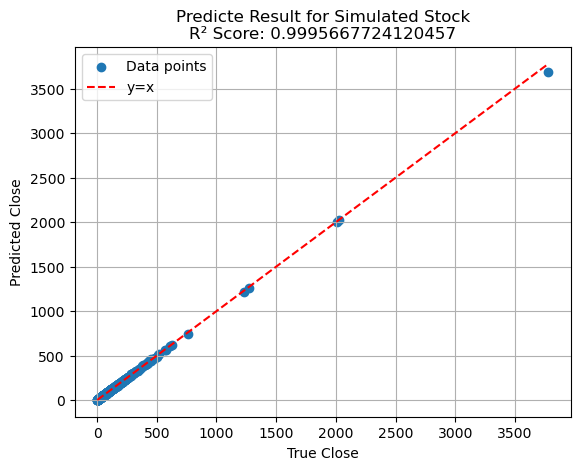

In [33]:
#Plot
plt.scatter(sim_result['true_y'], sim_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for Simulated Stock\nR² Score: {overall_r2_score}')

plt.plot([sim_result['true_y'].min(), sim_result['true_y'].max()], [sim_result['true_y'].min(), sim_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()